# ETH

# Importing Libraries

In [31]:
# Import TensorFlow library for building and training deep learning models.
import tensorflow as tf

# Import NumPy library for numerical operations, especially with arrays.
import numpy as np

# Import Pandas library for data manipulation and analysis, useful for handling tabular data.
import pandas as pd

# Import Matplotlib's pyplot module for data visualization and plotting graphs.
import matplotlib.pyplot as plt

# Import specific layers from TensorFlow Keras:
# - Dense: Fully connected neural network layer.
# - Input: Used to instantiate a Keras tensor.
# - Activation: Applies an activation function to an output.
from tensorflow.keras.layers import Dense, Input, Activation

# Import Model class from TensorFlow Keras, used to create a model instance.
from tensorflow.keras.models import Model

# Import metrics from scikit-learn for evaluating model performance:
# - mean_squared_error: Measures average squared difference between actual and predicted values.
# - mean_absolute_error: Measures average absolute difference between actual and predicted values.
# - r2_score: Provides the R² (coefficient of determination) regression score function.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import MinMaxScaler from scikit-learn to scale features to a given range, typically (0, 1).
from sklearn.preprocessing import MinMaxScaler


# Importing Dataset and Scaling it to feed into the model

In [32]:
# Read the CSV file "ETH.csv" into a Pandas DataFrame.
# - The 'parse_dates' parameter converts the "date" column into datetime objects.
# - 'dayfirst=True' specifies that the date format in the CSV has the day as the first element.
df = pd.read_csv("ETH.csv", parse_dates=["date"], dayfirst=True)

# Set the "date" column as the index of the DataFrame.
# This allows for time series operations and easier plotting with dates.
df.set_index("date", inplace=True)

# Create an instance of MinMaxScaler to scale all numerical columns.
# The scaler will transform the data so that all values are scaled to a range between 0 and 1.
scaler = MinMaxScaler()

# Fit the scaler to the DataFrame and transform the data.
# The result is converted back into a Pandas DataFrame, maintaining the original column names and index.
df_scaled = pd.DataFrame(scaler.fit_transform(df), 
                         columns=df.columns, 
                         index=df.index)


C:\Users\arjun\AppData\Local\Temp\ipykernel_30628\1257478616.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("ETH.csv", parse_dates=["date"], dayfirst=True)


# Train-Test Split (80-20)

In [33]:
# Calculate the size of the training set as 80% of the total number of rows in the scaled DataFrame.
train_size = int(len(df_scaled) * 0.8)

# Split the scaled DataFrame into a training set and a testing set using integer-location based indexing.
# The first 'train_size' rows are used for training.
train = df_scaled.iloc[:train_size]
# The remaining rows are used for testing.
test = df_scaled.iloc[train_size:]

# For modeling, we extract features and the target variable:
# - X_train and X_test: All columns are used as input features.
# - y_train and y_test: The target variable is set to be the second feature (i.e., the column at index 1).

# Convert the training DataFrame to a NumPy array for model input.
X_train = train.values
# Extract the second feature (column index 1) from the training set as the target variable.
y_train = train.iloc[:, 1].values

# Similarly, convert the testing DataFrame to a NumPy array for model input.
X_test = test.values
# Extract the second feature (column index 1) from the testing set as the target variable.
y_test = test.iloc[:, 1].values


# Neural Network with ExU (Exponentially Centered Unit) Function

In [34]:
# -------------------------
# Define custom ExU activation function
# -------------------------
def exu_activation(x):
    """
    Custom ExU (Exponentially-Centered Unit) activation function.
    This function applies a piecewise operation:
      - For elements of x that are greater than or equal to 0:
          f(x) = x (a linear function).
      - For elements of x that are less than 0:
          f(x) = tanh(x / 2), which provides a smooth, non-linear transformation.
    The negative part being centered around zero ensures smoother gradients and zero-mean outputs.
    """
    # tf.where selects x when condition (x >= 0) is True, otherwise it selects tanh(x/2).
    return tf.where(x >= 0, x, tf.math.tanh(x / 2))

# (Optional: Create a Keras Activation layer using the custom ExU activation function.)
# This can be used in model layers if you prefer using a predefined layer.
exu = Activation(exu_activation)

# -------------------------
# Build the neural network model
# -------------------------
# Define the input layer with a shape of (3,) since there are three input features.
input_layer = Input(shape=(3,))

# First hidden layer: Fully connected layer (Dense) with 64 units.
x = Dense(64)(input_layer)
# Apply the custom ExU activation function to the outputs of the first hidden layer.
x = Activation(exu_activation)(x)

# Second hidden layer: Another Dense layer with 32 units.
x = Dense(32)(x)
# Again, apply the custom ExU activation function to introduce non-linearity.
x = Activation(exu_activation)(x)

# Output layer: Dense layer with 1 unit since we're predicting a single continuous value.
output_layer = Dense(1)(x)

# Construct the model by specifying the input and output layers.
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with the following configurations:
# - Optimizer: 'adam' for efficient stochastic gradient descent.
# - Loss function: Mean Squared Error (mse) for regression tasks.
# - Metric: Mean Absolute Error (mae) to evaluate the performance during training.
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary to inspect the architecture.
model.summary()

# Train the model using the training data:
# - X_train and y_train as input and target respectively.
# - Train for 100 epochs.
# - Batch size of 16 for mini-batch gradient descent.
# - 20% of the training data will be used as a validation split.
# - 'verbose=1' enables the display of training progress.
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_split=0.2, 
                    verbose=1)

# Evaluate the model's performance on the test set:
# The evaluation returns the loss (mse) and mean absolute error (mae).
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,369 (9.25 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0749 - mae: 0.2187 - val_loss: 0.0045 - val_mae: 0.0647
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0414 - val_loss: 0.0016 - val_mae: 0.0341
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3835e-04 - mae: 0.0203 - val_loss: 0.0029 - val_mae: 0.0465
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6655e-04 - mae: 0.0165 - val_loss: 0.0018 - val_mae: 0.0356
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7786e-04 - mae: 0.0122 - val_loss: 0.0015 - val_mae: 0.0342
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4766e-04 - mae: 0.0089 - val_loss: 7.1432e-04 - val_mae: 0.0222
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1702e-04 - mae: 0.0081 - val_loss: 5.3343e-04 - val_mae: 0.0205
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5550e-05 - mae: 0.0062 - val_loss: 3.7163e-04 - val_mae: 0.0177
Epoch 9/100
36/36 ━━━━━━━━━━

# Neural Network Results

## Charts

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


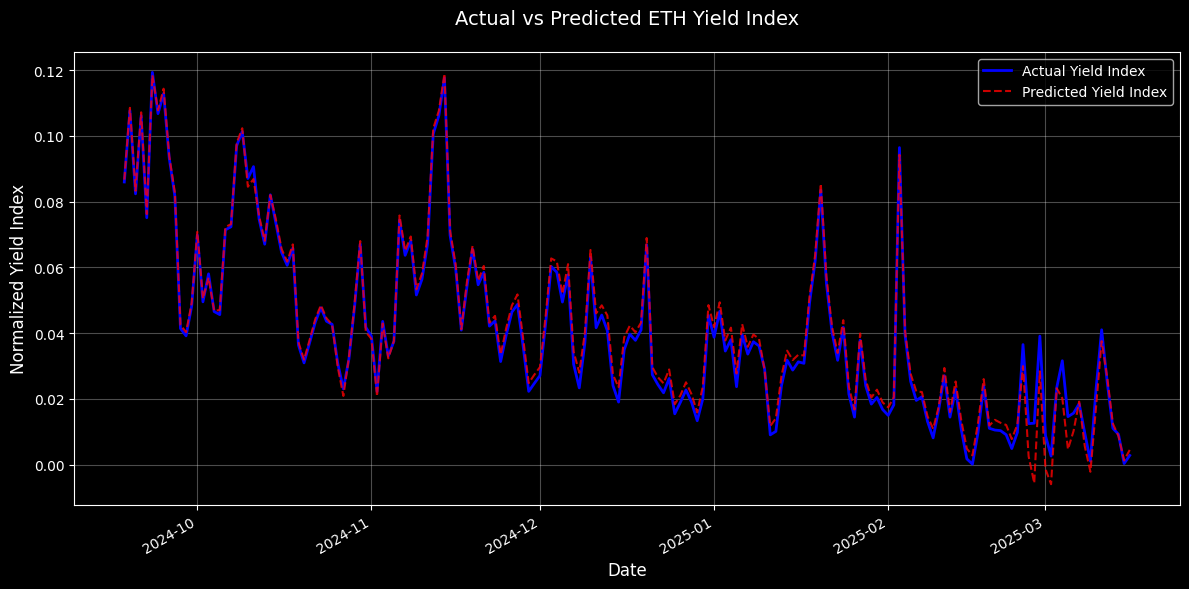

In [35]:
# Use the trained model to predict the target variable on the test set.
y_pred = model.predict(X_test)

# Convert predictions and actual target values into 1D NumPy arrays.
# This ensures that both y_pred and y_test have the same shape for evaluation and plotting.
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

# Retrieve the date index from the test DataFrame.
# The dates are already in datetime format from the earlier preprocessing.
dates = test.index

# Create a figure for plotting with a specified size.
plt.figure(figsize=(12, 6))

# Plot the actual target values over time.
# - 'dates' are used for the x-axis.
# - 'y_test' contains the actual values.
# - The plot is styled with a blue color and a thicker line width.
plt.plot(dates, y_test, label='Actual Yield Index', color='blue', linewidth=2)

# Plot the predicted target values over time.
# - 'dates' are used for the x-axis.
# - 'y_pred' contains the predicted values.
# - The plot is styled with a red dashed line and slight transparency.
plt.plot(dates, y_pred, label='Predicted Yield Index', 
         color='red', linestyle='--', alpha=0.8)

# Add a title to the plot with custom font size and padding.
plt.title('Actual vs Predicted ETH Yield Index', fontsize=14, pad=20)

# Label the x-axis as 'Date' with a specified font size.
plt.xlabel('Date', fontsize=12)
# Label the y-axis as 'Normalized Yield Index' with a specified font size.
plt.ylabel('Normalized Yield Index', fontsize=12)

# Add a legend to the plot to differentiate between actual and predicted data.
plt.legend(loc='upper right', fontsize=10)

# Enable a grid for better readability, with a low alpha for subtle lines.
plt.grid(True, alpha=0.3)

# Calculate the Mean Absolute Error (MAE) between the actual and predicted values.
mae = mean_absolute_error(y_test, y_pred)

# Automatically format the x-axis labels to show dates nicely (rotates and adjusts them).
plt.gcf().autofmt_xdate()

# Adjust the layout to ensure that labels and titles are not cut off.
plt.tight_layout()

# Display the plot on the screen.
plt.show()


## Metrics

In [36]:
# Generate predictions for both training and testing datasets
# Using the trained model to predict on:
# - Training features (X_train) to evaluate training performance
# - Testing features (X_test) to evaluate generalization performance
# The flatten() method converts any multi-dimensional output to 1D array
predictions = {
    'train': model.predict(X_train).flatten(),  # Predictions on training data
    'test': model.predict(X_test).flatten()     # Predictions on unseen test data
}

# Initialize dictionary to store performance metrics
metrics = {}

# Evaluate model performance on both training and test sets
for dataset in ['train', 'test']:
    # Select appropriate true values (y_train or y_test) based on dataset
    y_true = y_train if dataset == 'train' else y_test
    
    # Calculate key performance metrics:
    metrics[dataset] = {
        'mse': mean_squared_error(y_true, predictions[dataset]),  # Mean Squared Error - measures average squared difference
        'r2': r2_score(y_true, predictions[dataset])             # R² Score - measures proportion of variance explained
    }
    
    # Derive RMSE (Root Mean Squared Error) from MSE
    # RMSE is in same units as original data, more interpretable than MSE
    metrics[dataset]['rmse'] = np.sqrt(metrics[dataset]['mse'])

# Print R² score for test set (primary measure of model's predictive power)
# Formatted to 6 decimal places for precision
print(f"R² Score: {metrics['test']['r2']:.6f}")

# DAILY PERFORMANCE ANALYSIS SECTION
# =================================================

days_to_evaluate = 14

# Calculate daily prediction errors
# Note: What we call 'rmse' here is actually the square root of daily squared errors
daily_errors = {
    'rmse': np.sqrt((y_train[:days_to_evaluate] - predictions['train'][:days_to_evaluate]) ** 2)
}

# Print formatted daily performance table
print("\nPerformance Metrics")
print("="*60)
# Table columns:
# Day - Day number (1-14)
# Actual - True ETH value
# Predicted - Model's prediction
# RMSE - Square root of squared error (shows magnitude of error)
print("Day\tActual\t\tPredicted\t\tRMSE")
print("-"*60)

for day in range(days_to_evaluate):
    actual = y_train[day]                     # True ETH value for this day
    predicted = predictions['train'][day]      # Model's prediction
    error = daily_errors['rmse'][day]         # Error magnitude
    
    # Print formatted row with all values aligned
    # Using .6f precision for ETH values which are typically decimal numbers
    print(f"{day + 1:3d}\t{actual:.6f}\t{predicted:.6f}\t{error:.6f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² Score: 0.985346

Performance Metrics
Day	Actual		Predicted		RMSE
------------------------------------------------------------
  1	0.432091	0.432882	0.000791
  2	0.450039	0.451079	0.001040
  3	0.467203	0.468409	0.001205
  4	0.463300	0.464574	0.001274
  5	0.480669	0.482061	0.001392
  6	0.466419	0.467500	0.001081
  7	0.436779	0.437729	0.000950
  8	0.427590	0.428390	0.000801
  9	0.457473	0.458313	0.000840
 10	0.463655	0.464608	0.000953
 11	0.449049	0.449642	0.000592
 12	0.450936	0.451484	0.000548
 13	0.455194	0.456170	0.000976
 14	0.429028	0.429797	0.000770
